# LSTM 

## [1] 데이터 로딩

In [1]:
import json
import pandas as pd
import os
import matplotlib.pyplot as plt

In [2]:
path = 'C:/Users/USER/Desktop/data2/Validation/[라벨]General_val_A/district/'

In [3]:
keypoints = []
get_on = []
get_off = []

for i in os.listdir(path):
    os.listdir(path+i)
    file_list = os.listdir(path+i)
       
    for a in file_list:
        with open ((path+i+'/'+a),"r") as j:
            contents = json.loads(j.read())
            if len(contents['annotations']) != 0:
                keypoints.append(contents['annotations'][0]['keypoints'])
                get_on.append(contents['annotations'][0]['get_on'])
                get_off.append(contents['annotations'][0]['get_off'])        

In [4]:
# file_list = os.listdir(path)
# file_list_py = [file for file in file_list if file.endswith('.json')] ## 파일명 끝이 .json인 경우

In [5]:
df = pd.DataFrame({'keypoints':keypoints,
                   'get_on':get_on,
                   'get_off':get_off})

## [2] 데이터 전처리

In [6]:
get = []
for i in range(len(get_on)):
    if (df['get_on'][i] == False) and (df['get_off'][i] == False):
        get.append(2)
    elif (df['get_on'][i] == True) and (df['get_off'][i] == False):
        get.append(1)
    else:
        get.append(0)

In [7]:
df['get'] = get

In [8]:
df['get_off']

0         True
1         True
2         True
3         True
4         True
         ...  
16488    False
16489    False
16490    False
16491    False
16492    False
Name: get_off, Length: 16493, dtype: bool

In [9]:
import numpy as np

In [10]:
len(keypoints)

16493

In [11]:
keypoints = np.array(keypoints)

In [12]:
keypoints.shape

(16493, 48)

In [13]:
keypoints = keypoints.reshape(-1,16,3)

In [14]:
keypoints.shape

(16493, 16, 3)

In [15]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(get, num_classes=3)

In [16]:
y.shape

(16493, 3)

In [17]:
from sklearn.model_selection import train_test_split

In [18]:
x_train,x_test,y_train,y_test=train_test_split(keypoints,y,test_size=0.2,random_state=42)

## [3] 모델 생성

In [19]:
import tensorflow as tf

In [20]:
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.optimizers import Adam,SGD,RMSprop,Adagrad
from tensorflow.keras.callbacks import EarlyStopping

from keras.layers import Dropout, Flatten, LSTM, Bidirectional
from keras.layers import Conv2D, MaxPooling2D, Conv3D, MaxPool2D

### LSTM MODEL

In [21]:
# 검증 데이터에 대한 loss 값이 3번 연속 개선되지 않으면 학습 중지
stopCB = EarlyStopping(monitor='val_loss', patience=3)

In [22]:
model = Sequential()
model.add(LSTM(100, activation = 'tanh', input_shape=(16,3)))
model.add(Dense(50))
model.add(Dense(3, activation='softmax'))
model.summary()
 
# 3. 실행
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               41600     
                                                                 
 dense (Dense)               (None, 50)                5050      
                                                                 
 dense_1 (Dense)             (None, 3)                 153       
                                                                 
Total params: 46,803
Trainable params: 46,803
Non-trainable params: 0
_________________________________________________________________


In [23]:
hist = model.fit(x_train,y_train,epochs=30,batch_size=128,validation_split=0.2,callbacks=[stopCB])

Epoch 1/30
83/83 [==============================] - 10s 55ms/step - loss: 0.7912 - accuracy: 0.6058 - val_loss: 0.7784 - val_accuracy: 0.6256
Epoch 2/30
83/83 [==============================] - 3s 39ms/step - loss: 0.7716 - accuracy: 0.6117 - val_loss: 0.7695 - val_accuracy: 0.6328
Epoch 3/30
83/83 [==============================] - 3s 40ms/step - loss: 0.7663 - accuracy: 0.6152 - val_loss: 0.7781 - val_accuracy: 0.6150
Epoch 4/30
83/83 [==============================] - 3s 39ms/step - loss: 0.7624 - accuracy: 0.6226 - val_loss: 0.7598 - val_accuracy: 0.6461
Epoch 5/30
83/83 [==============================] - 3s 39ms/step - loss: 0.7507 - accuracy: 0.6331 - val_loss: 0.7405 - val_accuracy: 0.6620
Epoch 6/30
83/83 [==============================] - 3s 39ms/step - loss: 0.7374 - accuracy: 0.6458 - val_loss: 0.7447 - val_accuracy: 0.6370
Epoch 7/30
83/83 [==============================] - 3s 39ms/step - loss: 0.7386 - accuracy: 0.6386 - val_loss: 0.7492 - val_accuracy: 0.6400
Epoch 8/30
8

In [24]:
model.evaluate(x_test,y_test)

104/104 [==============================] - 1s 7ms/step - loss: 0.7091 - accuracy: 0.6554


[0.7090833783149719, 0.6553500890731812]

### 양방향 LSTM MODEL

In [25]:
model2 = Sequential()
model2.add(Bidirectional(LSTM(50, activation = 'tanh', input_shape=(16,3))))
model2.add(Bidirectional(LSTM(50)))
model2.add(Dense(30))
model2.add(Dense(3, activation='softmax'))
model2.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

model2 = Sequential()
forward_layer = LSTM(50)
backward_layer = LSTM(50, activation='tanh', go_backwards=True)
model2.add(Bidirectional(forward_layer, backward_layer=backward_layer, input_shape=(16,3)))
model2.add(Dense(30))
model2.add(Dense(3, activation='softmax'))
model2.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [26]:
model2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_2 (Bidirectio  (None, 100)              21600     
 nal)                                                            
                                                                 
 dense_4 (Dense)             (None, 30)                3030      
                                                                 
 dense_5 (Dense)             (None, 3)                 93        
                                                                 
Total params: 24,723
Trainable params: 24,723
Non-trainable params: 0
_________________________________________________________________


In [27]:
hist2 = model2.fit(x_train,y_train,epochs=30,batch_size=128,validation_split=0.2,callbacks=[stopCB])

Epoch 1/30
83/83 [==============================] - 14s 55ms/step - loss: 0.7853 - accuracy: 0.6067 - val_loss: 0.7684 - val_accuracy: 0.6116
Epoch 2/30
83/83 [==============================] - 2s 26ms/step - loss: 0.7632 - accuracy: 0.6137 - val_loss: 0.7610 - val_accuracy: 0.6355
Epoch 3/30
83/83 [==============================] - 2s 26ms/step - loss: 0.7554 - accuracy: 0.6147 - val_loss: 0.7537 - val_accuracy: 0.6396
Epoch 4/30
83/83 [==============================] - 2s 26ms/step - loss: 0.7511 - accuracy: 0.6147 - val_loss: 0.7588 - val_accuracy: 0.6252
Epoch 5/30
83/83 [==============================] - 2s 23ms/step - loss: 0.7458 - accuracy: 0.6212 - val_loss: 0.7542 - val_accuracy: 0.6264
Epoch 6/30
83/83 [==============================] - 2s 24ms/step - loss: 0.7420 - accuracy: 0.6289 - val_loss: 0.7408 - val_accuracy: 0.6415
Epoch 7/30
83/83 [==============================] - 2s 26ms/step - loss: 0.7298 - accuracy: 0.6328 - val_loss: 0.7361 - val_accuracy: 0.6484
Epoch 8/30
8

## [4] 모델 평가

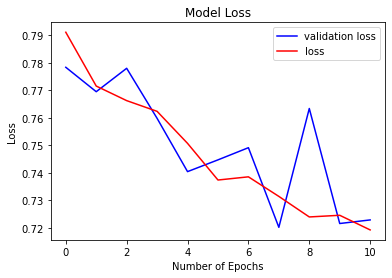

In [28]:
plt.plot(hist.history['val_loss'], color='b', label="validation loss")
plt.plot(hist.history['loss'], color='red', label="loss")
plt.title("Model Loss")
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

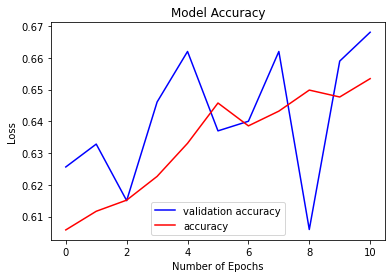

In [29]:
plt.plot(hist.history['val_accuracy'], color='b', label="validation accuracy")
plt.plot(hist.history['accuracy'], color='red', label="accuracy")
plt.title("Model Accuracy")
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [30]:
test_data = [
                1119,
                525,
                2,
                1134,
                428,
                2,
                1233,
                414,
                1,
                1283,
                445,
                1,
                1217,
                519,
                2,
                1161,
                695,
                2,
                1254,
                428,
                1,
                1259,
                331,
                2,
                1246,
                244,
                2,
                1207,
                206,
                2,
                1155,
                386,
                1,
                1230,
                367,
                1,
                1281,
                224,
                2,
                1249,
                296,
                2,
                1230,
                388,
                2,
                1115,
                351,
                2
            ]

In [31]:
model2.predict(np.array(test_data).reshape(-1,16,3))

1/1 [==============================] - 2s 2s/step


array([[0.33817637, 0.01976158, 0.64206207]], dtype=float32)

In [32]:
model2.evaluate(x_test,y_test)

104/104 [==============================] - 1s 6ms/step - loss: 0.7150 - accuracy: 0.6544


[0.7149749398231506, 0.6544407606124878]